# 0. Overview

# Shakespeare

William Shakespeare produced plays of various genres; tragedy was one of the genres that made him famous. Provided that William Shakespeare was a major playwright and that his literary production was influenced, to whatever extent, by the social contexts and interests, we would like to use SQL to query certain general and complexed questions by focusing mainly on his tragedies.


### Data
The dataset that we use is 'Shakespeare.csv'.
It contains four tables with the following details:
1. Works: id, Title, LongTitle, Date, GenreType
2. Paragraphs: id, ParagraphNum, PlainText, character_id, chapter_id
3. Characters: id, CharName, Abbrev, Description
4. Chapters: id, Act, Scene, Description, work_id

### In this notebook we will:
1. Contain a quantitive analysis concerning years of production, characters, and stylistics related to the tragedy production by William Shakespeare.
2. Divide the periods of study into two: the Elizabethan age (1558 - 1603 A.D.) and the rise of the Stuart Monarchy (1604 - 1714 A.D.). 
3. Run text queries to find out about the following subjects: 
    Years related to tragedy production,
    Frequency of character presence,
    Stylistical changes found in Shakespeare's drama.
4. Visualise outcomes for easier interpretation.

# I. Presetting 

### 0.Connecting to our database

In [5]:
#(1)importing the necessary libraries
import mysql.connector 
import pandas as pd
import matplotlib.pyplot as plt 
import re
import sqlalchemy 
from sqlalchemy.dialects.mysql import LONGTEXT
import gender_guesser.detector # package to guess the name's genders

In [7]:
#(2) defining the credentials
username = "root"
password = ""
host = "localhost"

#(3)creating the connection to our mysql
conn = mysql.connector.connect(host=host,user=username,passwd=password)

#(4)creating our database cursor that will allow us to execute SQL queries to our connected database
cursor = conn.cursor(buffered=True)

#(5)using the dataset Shakespeare
cursor.execute("USE Shakespeare");

In [3]:
#（6）checking if we are connected and ready to go
if conn.is_connected(): # use if the test the bug
    print("Our connection to our database is successful")
else:
    print("Our connection to our database is unsuccessful")

Our connection to our database is successful


# II. SQL queries

### Year

#### Question 1.1
How many tragedies did William Shakespeare create in his lifetime? 

In [144]:
# Count the total number of tragedies during William Shakespeare's lifetime
sql_query = """
    SELECT GenreType,COUNT(*) AS Total_number
    FROM works
    WHERE GenreType LIKE 'Tragedy'
    Order by date
"""
pd.read_sql(sql_query, conn)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,GenreType,Total_number
0,Tragedy,11


He created 11 tragedies in all his lifetime.​

#### Question 1.2

How many and what tragedies did he produce during the Elizabethan era (1558 - 1603 A.D.) and the rise of the Stuart Monarchy (1604 - 1714 A.D.)?​ Does that show any change?

In [145]:
# Count the number of tragedies he created in two periods
sql_query = """
SELECT 
    COUNT(Title) AS Total_CreationCount,
    SUM(CASE 
            WHEN Date BETWEEN 1558 AND 1603 THEN 1
            ELSE 0
        END
        ) AS Creation_in_The_Elizabethan_period,
    SUM(CASE 
            WHEN Date BETWEEN 1603 AND 1714 THEN 1
            ELSE 0
        END
        ) AS Creation_in_The_rise_of_the_Stuart_Monarchy_period  
FROM works
WHERE GenreType LIKE 'Tragedy';
"""
pd.read_sql(sql_query, conn)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Total_CreationCount,Creation_in_The_Elizabethan_period,Creation_in_The_rise_of_the_Stuart_Monarchy_period
0,11,5.0,6.0


In [146]:
# List all tragedies he created in two periods
sql_query = """
    SELECT Title,GenreType,Date,
    CASE 
        WHEN Date BETWEEN 1558 AND 1603 THEN 'The Elizabethan period'
        WHEN Date BETWEEN 1603 AND 1714 THEN 'The rise of the Stuart Monarchy period '
        ELSE 'Other Period'
    END AS Prodcution_Period
    FROM works
    WHERE GenreType LIKE 'Tragedy'
    ORDER BY Date ASC;
"""
pd.read_sql(sql_query, conn)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Title,GenreType,Date,Prodcution_Period
0,Titus Andronicus,Tragedy,1593,The Elizabethan period
1,Romeo and Juliet,Tragedy,1594,The Elizabethan period
2,Julius Caesar,Tragedy,1599,The Elizabethan period
3,Hamlet,Tragedy,1600,The Elizabethan period
4,Troilus and Cressida,Tragedy,1601,The Elizabethan period
5,Othello,Tragedy,1604,The rise of the Stuart Monarchy period
6,Macbeth,Tragedy,1605,The rise of the Stuart Monarchy period
7,King Lear,Tragedy,1605,The rise of the Stuart Monarchy period
8,Antony and Cleopatra,Tragedy,1606,The rise of the Stuart Monarchy period
9,Timon of Athens,Tragedy,1607,The rise of the Stuart Monarchy period


William Shakespeared produced 5 tragedies during the Elizabethan period. 
It was likely that he was interested in producign the other genres, or that he had to manage the Lord Chamberlain's Men, a theater company, of which he was a shareholder.

William Shakespeare produced 6 tragedies during the rise of the Stuart monarchy.
The potential reasons are because of the increase in popularity of theatre in general and the pressure from theatres themselves.

#### Question 1.3
Did he produce more in any specific year? What is his production distribution of tragedy during these two periods？

In [147]:
# Count the number of tragedies he created per year during two periods.
sql_query = """
    SELECT Date, COUNT(*) AS Count,
    CASE 
        WHEN Date BETWEEN 1558 AND 1603 THEN 'The Elizabethan period'
        WHEN Date BETWEEN 1603 AND 1714 THEN 'The rise of the Stuart Monarchy period '
        ELSE 'Other Period'
    END AS Prodcution_Period
    FROM works
    WHERE GenreType LIKE '%Tragedy%'
    GROUP BY Date;
"""
pd.read_sql(sql_query, conn)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Date,Count,Prodcution_Period
0,1593,1,The Elizabethan period
1,1594,1,The Elizabethan period
2,1599,1,The Elizabethan period
3,1600,1,The Elizabethan period
4,1601,1,The Elizabethan period
5,1604,1,The rise of the Stuart Monarchy period
6,1605,2,The rise of the Stuart Monarchy period
7,1606,1,The rise of the Stuart Monarchy period
8,1607,2,The rise of the Stuart Monarchy period


/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<Figure size 432x288 with 0 Axes>

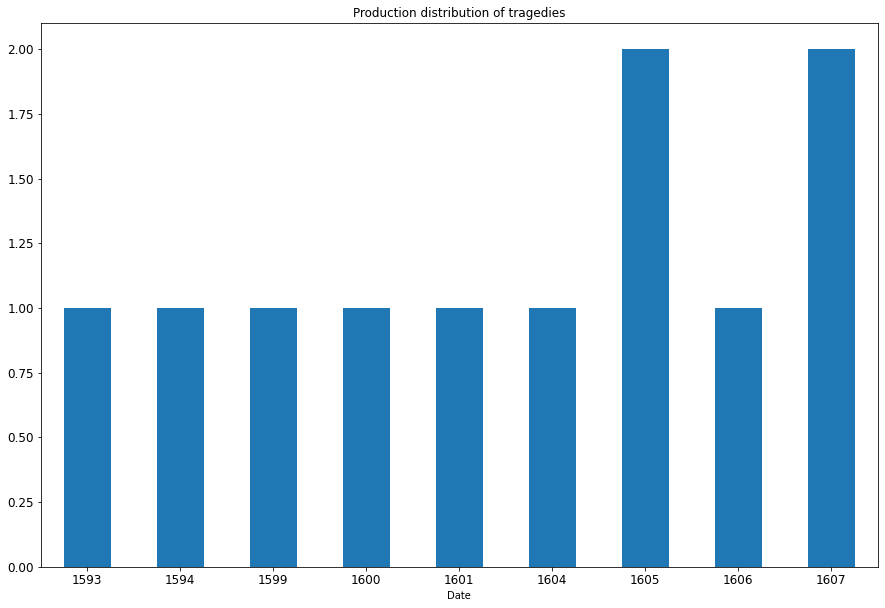

In [148]:
# Visualize it 
df1 = pd.read_sql(sql_query, conn)
df1 = df1.set_index('Date'); 
plt.figure()
ax1 = df1[['Count']].plot(
    kind='bar',
    title ="Production distribution of tragedies",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
plt.show()

We find out that his normal frequency was one play per year from 1593 to 1607. (expect the period 1594-1599 and 1601-1604). Nonetheless, in 1605 and 1607, he reached his peak as he produced two plays per year respectively. It could be caused by the higher demands for tragedies after Shakespeare found out that this genre was popular and favoured amongst the British audience.

#### Question 1.4

Which are the tragedies he created in the same year?​

In [41]:
# List tragedies that Shakespeare produced in the same year.
sql_query = """
    SELECT w1.Title,w2.Title,w1.Date
    FROM works w1 
    JOIN works w2
    ON w1.Date = w2.Date 
    WHERE w1.GenreType LIKE '%Tragedy'
        AND w2.GenreType LIKE '%Tragedy'
        AND w1.Title != w2.Title
    GROUP BY w2.Date
    ORDER BY w1.Date
"""
pd.read_sql(sql_query, conn)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Title,Title,Date
0,Macbeth,King Lear,1605
1,Timon of Athens,Coriolanus,1607


There're no specific reasons why he produced two tragedies in one year. The potential cause could be the pressure from the company which was in charge of the theatre which put more pressure on him to serve the audience.

### Character

#### Question 2.1
For investigation, we would like to observe all characters showed in tragedies by browsing through the characters table.What were the characters showed in all tragedies?

In [12]:
# List all the characters from different tragedies
cursor.execute("""
    SELECT DISTINCT c.CharName,w.Title
    FROM works w
    JOIN chapters chap
    ON w.id = chap.work_id
    JOIN paragraphs AS p
    ON chap.id = p.chapter_id
    JOIN characters AS c
    ON p.character_id = c.id
    WHERE LOWER(GenreType) LIKE 'tragedy' 
""")
q2b=cursor.fetchall()
q2b

[('(stage directions)', 'Antony and Cleopatra'),
 ('Philo', 'Antony and Cleopatra'),
 ('Cleopatra', 'Antony and Cleopatra'),
 ('Antony', 'Antony and Cleopatra'),
 ('Attendant', 'Antony and Cleopatra'),
 ('Demetrius', 'Antony and Cleopatra'),
 ('Charmian', 'Antony and Cleopatra'),
 ('Alexas', 'Antony and Cleopatra'),
 ('Soothsayer', 'Antony and Cleopatra'),
 ('Domitius Enobarus', 'Antony and Cleopatra'),
 ('Iras', 'Antony and Cleopatra'),
 ('Messenger', 'Antony and Cleopatra'),
 ('First Attendant', 'Antony and Cleopatra'),
 ('Second Attendant', 'Antony and Cleopatra'),
 ('Second Messenger', 'Antony and Cleopatra'),
 ('Octavius', 'Antony and Cleopatra'),
 ('Lepidus', 'Antony and Cleopatra'),
 ('Mardian', 'Antony and Cleopatra'),
 ('Pompey', 'Antony and Cleopatra'),
 ('Menecrates', 'Antony and Cleopatra'),
 ('Menas', 'Antony and Cleopatra'),
 ('Varrius', 'Antony and Cleopatra'),
 ('Mecaenas', 'Antony and Cleopatra'),
 ('Agrippa', 'Antony and Cleopatra'),
 ('Octavia', 'Antony and Cleopatra

#### Question 2.2
Which characters appeared the most frequently in all his tragedies?/ Who are the protagonists? 

In [11]:
# List characters which appeared the most frequently from both periods in all his tragedies.
sql_query3 ="""
    SELECT c.CharName,
        SUM(COUNT(*)) OVER (PARTITION BY c.CharName) AS CharName_Count
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE Title = ANY (SELECT Title FROM works WHERE GenreType = 'Tragedy')
    GROUP BY c.CharName
    HAVING COUNT(c.CharName)>100
    ORDER BY COUNT(*)desc;
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10) # get the top 10 popluar chracters in his tragedies

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,CharName_Count
0,(stage directions),1361.0
1,Hamlet,358.0
2,Othello,274.0
3,Iago,272.0
4,Antony,253.0
5,Timon,210.0
6,Cleopatra,204.0
7,Brutus,194.0
8,Coriolanus,189.0
9,Lear,188.0


In [12]:
df3.columns=['CharName','NumberOfAppearance']

<Figure size 432x288 with 0 Axes>

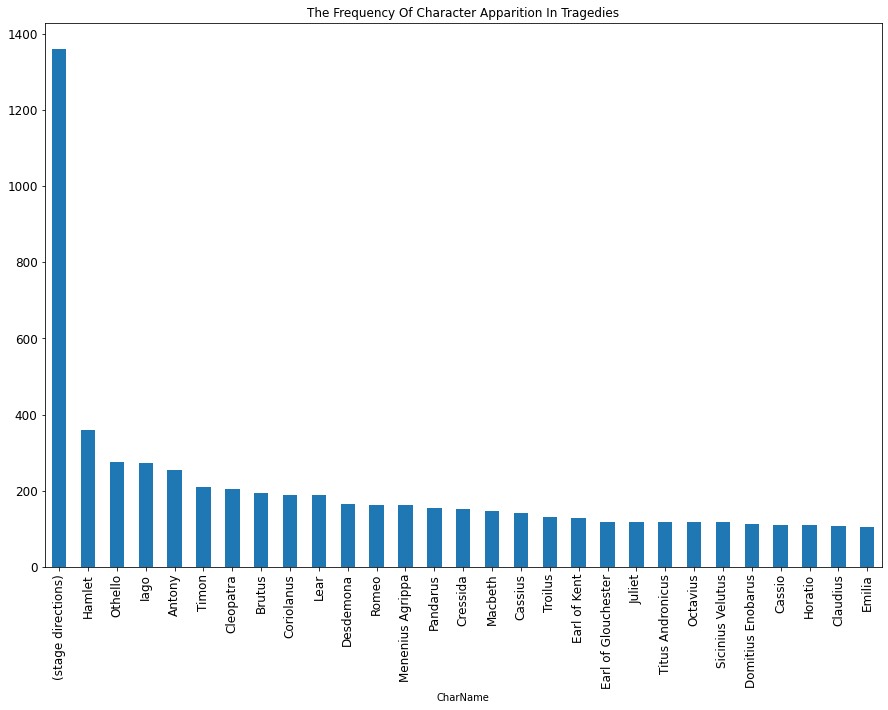

In [13]:
# vislize 
df3 = df3.set_index('CharName')
plt.figure()
ax3 = df3[['NumberOfAppearance']].plot(
    kind='bar',
    title ="The Frequency Of Character Apparition In Tragedies",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
plt.show()

Among all the periods and tragedies, Hamlet appeared the most frequently in all tragedies.  This is because Hamlet is regarded as the longest tragedy as it has the most lines: 4,042 lines. It contains many lines, scenes, and subplots. 

#### Question 2.3

Which character appeared the most frequently in his tragedies in both period? Compare the characters that appear the most in two periods. Does that change over time?

In [166]:
# List characters that appear the most in Elizabethan period (1558-1603) in his tragedies 
sql_query3 ="""
    SELECT c.CharName, COUNT(*) AS total_number
    FROM characters AS c
    JOIN paragraphs AS p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE GenreType LIKE '_ragedy' AND Date BETWEEN 1558 AND 1603
    GROUP BY c.CharName
    ORDER BY COUNT(*)desc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,total_number
0,(stage directions),627
1,Hamlet,358
2,Brutus,194
3,Romeo,163
4,Pandarus,153
5,Cressida,152
6,Cassius,140
7,Troilus,131
8,Juliet,118
9,Titus Andronicus,117


In [167]:
# List characters that appear the most in the rise of the Stuart Monarchy period (1603 - 1714) in his tragedies 
sql_query3 ="""
    SELECT c.CharName, COUNT(*) AS total_number
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE (LOWER(w.GenreType) LIKE 'tragedy' AND w.Date BETWEEN 1603 AND 1714)
    GROUP BY c.CharName
    ORDER BY COUNT(*)desc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,total_number
0,(stage directions),734
1,Othello,274
2,Iago,272
3,Timon,210
4,Cleopatra,204
5,Antony,202
6,Coriolanus,189
7,Lear,188
8,Desdemona,165
9,Menenius Agrippa,162


The frequency of character presence changed over time. Hamlet had the most scenes from all Shakespearean tragedies; and during the rise of the Stuart Monarchy period (1603 - 1714), Othello had the most scenes. 

Hamlet had more presences only because the story was longer as Shakespeare extended the length of Hamlet because he wanted to include many details, whereas in Othello, Shakespeare did not put much details compared to its counterpart from the former period.

#### Question 2.4
Which character appeared the least frequently in all his tragedies?​

In [168]:
# List characters that appears the least from both periods in all his tragedies.
sql_query4 ="""
    SELECT c.CharName, COUNT(*) AS total_number
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE LOWER(GenreType) LIKE 'tragedy'
    GROUP BY c.CharName
    HAVING COUNT(*) =(
    SELECT Min(a.total_number)
    FROM (
        SELECT c.CharName, COUNT(*) AS total_number
        FROM characters c
        JOIN paragraphs p
        ON c.id = p.character_id
        JOIN chapters AS chap
        ON p.chapter_id = chap.id
        JOIN works AS w
        ON chap.work_id = w.id
        WHERE LOWER(GenreType) LIKE 'tragedy'
        GROUP BY c.CharName
        ) a
    )
"""
df4 = pd.read_sql(sql_query4, conn)
df4.head(50)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,total_number
0,All Citizens,1
1,All Ladies,1
2,All the Goths,1
3,All The People,1
4,Ambassador,1
5,Attendants,1
6,Both Citizens,1
7,Cornelius,1
8,Cupid,1
9,Fifth Citizen,1


 Characters which appear only once are mostly anonymous, some with professions, the other not even identified. 

#### Question 2.5
Compare the characters that appear the least in two periods in tragedies.

In [170]:
# List characters that appears the least in Elizabethan period (1558-1603) in his tragedies 
sql_query4 ="""
    SELECT DISTINCT c.CharName, COUNT(*) AS total_number
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE (LOWER(w.GenreType) LIKE 'tragedy' AND w.Date BETWEEN 1558 AND 1603)
    GROUP BY c.CharName
    HAVING COUNT(*) =(
    SELECT Min(a.total_number)
    FROM (
        SELECT c.CharName, COUNT(*) AS total_number
        FROM characters c
        JOIN paragraphs p
        ON c.id = p.character_id
        JOIN chapters AS chap
        ON p.chapter_id = chap.id
        JOIN works AS w
        ON chap.work_id = w.id
        WHERE (LOWER(w.GenreType) LIKE 'tragedy' AND w.Date BETWEEN 1558 AND 1603)
        GROUP BY c.CharName
        ) a
    )
"""
df4 = pd.read_sql(sql_query4, conn)
df4.head(20)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,total_number
0,All the Goths,1
1,Ambassador,1
2,Captain,1
3,Cornelius,1
4,First Commoner,1
5,Gentlemen,1
6,Helenus,1
7,Myrmidons,1
8,Second Goth,1
9,Second Watchman,1


In [177]:
# List characters that appears the least in the rise of the Stuart Monarchy period (1603 - 1714) in his tragedies 
sql_query4 ="""
    SELECT c.CharName, COUNT(*) AS total_number
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE (LOWER(w.GenreType) LIKE 'tragedy' AND w.Date BETWEEN 1603 AND 1714)
    GROUP BY c.CharName
    HAVING COUNT(*) =(
    SELECT Min(a.total_number)
    FROM (
        SELECT c.CharName, COUNT(*) AS total_number
        FROM characters c
        JOIN paragraphs p
        ON c.id = p.character_id
        JOIN chapters AS chap
        ON p.chapter_id = chap.id
        JOIN works AS w
        ON chap.work_id = w.id
        WHERE (LOWER(w.GenreType) LIKE 'tragedy' AND w.Date BETWEEN 1603 AND 1714)
        GROUP BY c.CharName
        ) a
    )
"""
df4 = pd.read_sql(sql_query4, conn)
df4.head(30)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,CharName,total_number
0,All Citizens,1
1,All Ladies,1
2,All The People,1
3,Attendants,1
4,Both Citizens,1
5,Cupid,1
6,Fifth Citizen,1
7,First Apparition,1
8,First Gentleman,1
9,First Lady,1


Both periods have a lot of characters with sole presence, but higher during the rise of the Stuart Monarchy. 

During the Elizabethan era: many supporting characters to make the stories more detailed to educate the public audience about drama convention.

During the rise of the Stuart monarchy, there were more supporting roles to respond to the more detailed stories that people like; to respond to bigger sizes of theatres that could cater more performers.

### Stylistics

#### Question 3.1
Had the lengths of tragedy titles changed over time ?​

In [51]:
# List the length of title of his tragedies in different time 
sql_query3 ="""
    SELECT LENGTH(Title),Title,Date,
    CASE 
        WHEN Date BETWEEN 1558 AND 1603 THEN 'The Elizabethan period'
        WHEN Date BETWEEN 1603 AND 1714 THEN 'The rise of the Stuart Monarchy period '
        ELSE 'Other Period'
    END AS Prodcution_Period
    FROM works AS w
    WHERE LOWER(w.GenreType) LIKE 'tragedy'
    ORDER BY Date ASC
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(15)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,LENGTH(Title),Title,Date,Prodcution_Period
0,16,Titus Andronicus,1593,The Elizabethan period
1,16,Romeo and Juliet,1594,The Elizabethan period
2,13,Julius Caesar,1599,The Elizabethan period
3,6,Hamlet,1600,The Elizabethan period
4,20,Troilus and Cressida,1601,The Elizabethan period
5,7,Othello,1604,The rise of the Stuart Monarchy period
6,7,Macbeth,1605,The rise of the Stuart Monarchy period
7,9,King Lear,1605,The rise of the Stuart Monarchy period
8,20,Antony and Cleopatra,1606,The rise of the Stuart Monarchy period
9,15,Timon of Athens,1607,The rise of the Stuart Monarchy period


<Figure size 432x288 with 0 Axes>

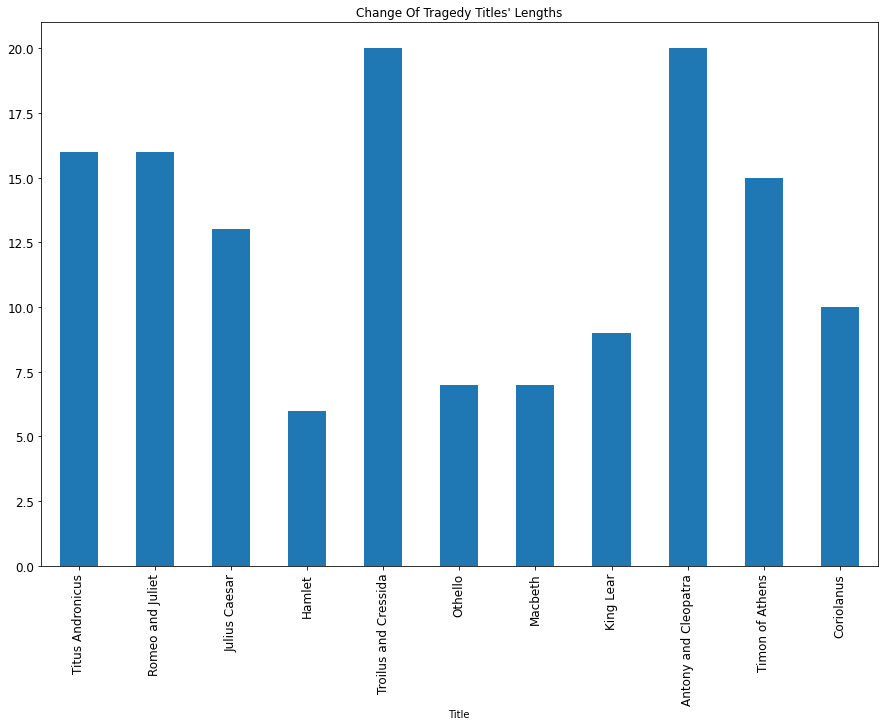

In [52]:
# visualize
df3 = df3.set_index('Title'); 
plt.figure()
ax3 = df3[['LENGTH(Title)']].plot(
    kind='bar',
    title ="Tragedy Titles' Lengths Change Over Time",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
plt.show()

During both periods, the title lengths were unstable and changed all the time. In the Elizabethan era, the long titles were meant to provide many details to the audience. In the latter, the long titles didn't function as such, but they were more of word plays and stylistics.

#### Question 3.2
What is the average length of the title in all tragedies in both periods? 

In [89]:
# Compute the average length of the title in all his tragidies all the time
cursor.execute("USE Shakespeare")
sql_query4 ="""
    SELECT GenreType,AVG(LENGTH(Title))
    FROM works AS w
    WHERE GenreType LIKE 'tragedy' 
"""
df4 = pd.read_sql(sql_query4, conn)
df4.head()

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,GenreType,AVG(LENGTH(Title))
0,Tragedy,12.6364


Overall, when creating tragedies, he usually controlled the title length to be about 12.6364.​

#### Question 3.3
Although 'you' was a common pronoun during William Shakespeare's lifetime, the pronoun 'thou' was still used in plays. Hence, what were the frequency of the terms 'thou', 'thee', 'thy', and 'thine' in his tragedies?​

In [90]:
# Count the number of word 'thou' in all his tragidies all the time
cursor.execute("USE Shakespeare")
sql_query3 ="""
    SELECT p.PlainText,COUNT(*) AS total_number,Date,Title
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE GenreType = 'Tragedy' AND p.PlainText LIKE '%thou%' 
    GROUP BY w.Title
    Order by Date asc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,PlainText,total_number,Date,Title
0,How fair the tribune speaks to calm my thoughts!,153,1593,Titus Andronicus
1,But thou art not quickly moved to strike.,185,1594,Romeo and Juliet
2,"Hence! home, you idle creatures get you home:\...",82,1599,Julius Caesar
3,"Thou art a scholar; speak to it, Horatio.",128,1600,Hamlet
4,Call here my varlet; I'll unarm again:\nWhy sh...,140,1601,Troilus and Cressida
5,Tush! never tell me; I take it much unkindly\n...,153,1604,Othello
6,I thought the King had more affected the Duke ...,175,1605,King Lear
7,This is the sergeant\nWho like a good and hard...,101,1605,Macbeth
8,"Then must thou needs find out new heaven, new ...",169,1606,Antony and Cleopatra
9,"I say unto you, what he hath done famously, he...",100,1607,Coriolanus


<Figure size 432x288 with 0 Axes>

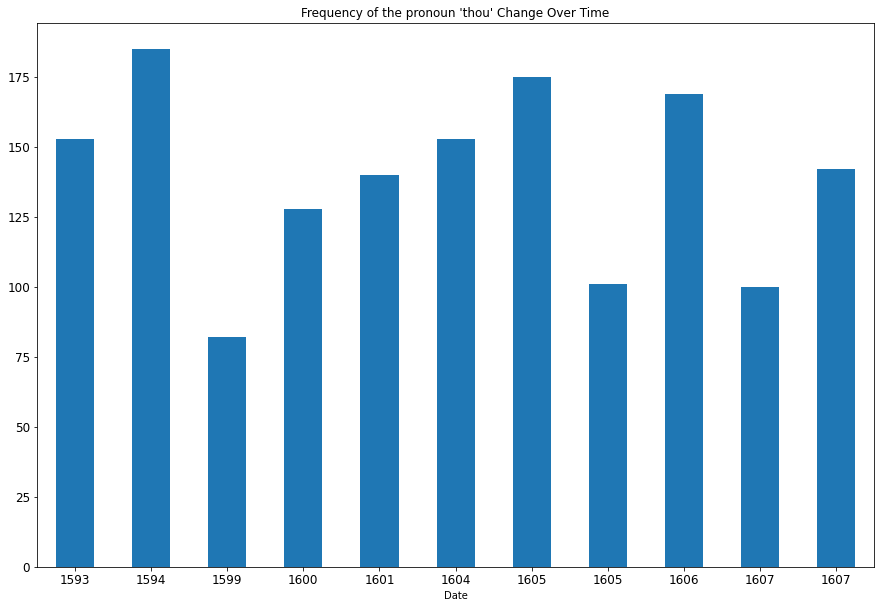

In [75]:
# Visualize 
df3 = df3.set_index('Date'); 
plt.figure()
ax3 = df3[['total_number']].plot(
    kind='bar',
    title ="Frequency of the pronoun 'thou' Change Over Time",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
for tick in ax3.get_xticklabels():
    tick.set_rotation(0)

plt.show()

In [64]:
# Count the number of word 'thee' in all his tragidies all the time
cursor.execute("USE Shakespeare")
sql_query3 ="""
    SELECT p.PlainText,COUNT(*) AS total_number,Date,Title
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE LOWER(w.GenreType) LIKE 'tragedy' AND p.PlainText LIKE '%thee%' 
    GROUP BY Title
    Order by Date asc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,PlainText,total_number,Date,Title
0,"Marcus Andronicus, so I do ally\nIn thy uprigh...",73,1593,Titus Andronicus
1,That shows thee a weak slave; for the weakest ...,105,1594,Romeo and Juliet
2,Would he were fatter! But I fear him not:\nYet...,39,1599,Julius Caesar
3,"'Tis now struck twelve. Get thee to bed, Franc...",46,1600,Hamlet
4,"I was about to tell thee:--when my heart,\nAs ...",65,1601,Troilus and Cressida
5,The worser welcome:\nI have charged thee not t...,69,1604,Othello
6,"Of all these bounds, even from this line to th...",114,1605,King Lear
7,So well thy words become thee as thy wounds;\n...,43,1605,Macbeth
8,"Nay, hear them, Antony:\nFulvia perchance is a...",89,1606,Antony and Cleopatra
9,He that will give good words to thee will flat...,51,1607,Coriolanus


<Figure size 432x288 with 0 Axes>

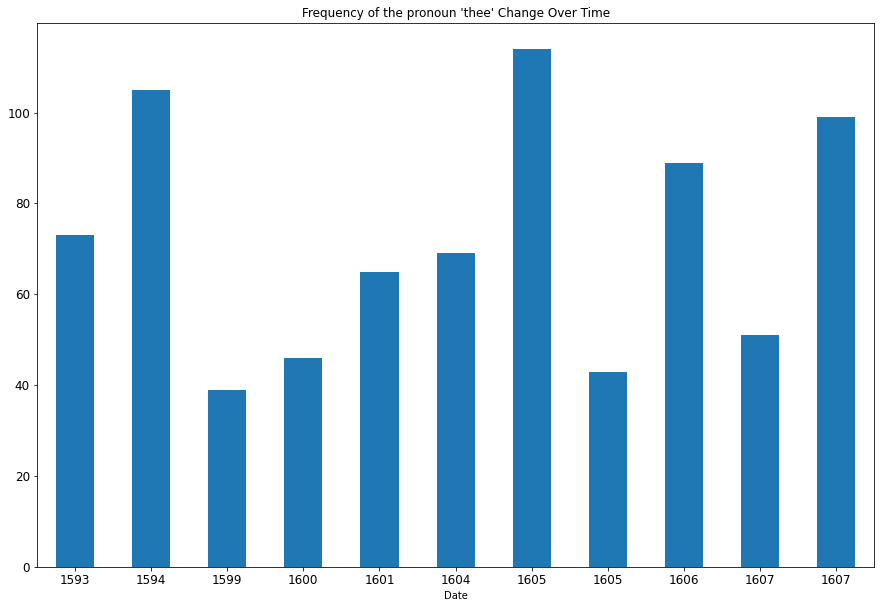

In [65]:
# visualize
df3 = df3.set_index('Date'); 
plt.figure()
ax3 = df3[['total_number']].plot(
    kind='bar',
    title ="Frequency of the pronoun 'thee' Change Over Time",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
for tick in ax3.get_xticklabels():
    tick.set_rotation(0)

plt.show()

In [68]:
# Count the number of word 'thy' in all his tragidies all the time
cursor.execute("USE Shakespeare")
sql_query3 ="""
    SELECT p.PlainText,COUNT(*) AS total_number,Date,Title
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE LOWER(w.GenreType) LIKE 'tragedy' AND p.PlainText LIKE '%thy%' 
    GROUP BY Title
    Order by Date asc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,PlainText,total_number,Date,Title
0,"Marcus Andronicus, so I do ally\nIn thy uprigh...",112,1593,Titus Andronicus
1,"'Tis well thou art not fish; if thou hadst, th...",97,1594,Romeo and Juliet
2,Where is thy leather apron and thy rule?\nWhat...,43,1599,Julius Caesar
3,As thou art to thyself.\nSuch was the very arm...,60,1600,Hamlet
4,"O Pandarus! I tell thee, Pandarus,--\nWhen I d...",70,1601,Troilus and Cressida
5,Thou told'st me thou didst hold him in thy hate.,64,1604,Othello
6,But goes thy heart with this?,104,1605,King Lear
7,"Fair is foul, and foul is fair:\nHover through...",53,1605,Macbeth
8,"Perchance! nay, and most like:\nYou must not s...",94,1606,Antony and Cleopatra
9,Worthy Menenius Agrippa; one that hath always ...,72,1607,Coriolanus


<Figure size 432x288 with 0 Axes>

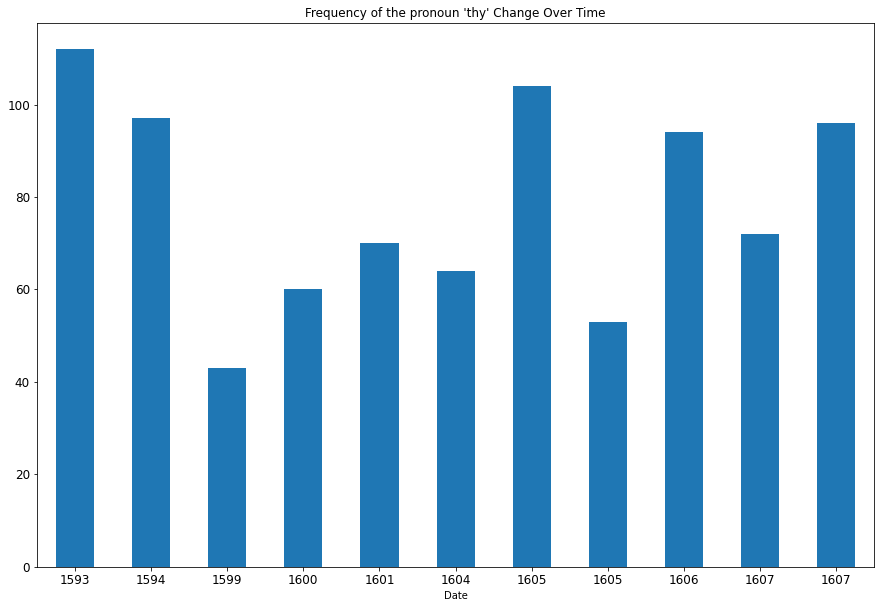

In [69]:
# visualize
df3 = df3.set_index('Date'); 
plt.figure()
ax3 = df3[['total_number']].plot(
    kind='bar',
    title ="Frequency of the pronoun 'thy' Change Over Time",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
for tick in ax3.get_xticklabels():
    tick.set_rotation(0)

plt.show()

In [178]:
# Count the number of word 'thine' in all his tragidies all the time
cursor.execute("USE Shakespeare")
sql_query3 ="""
    SELECT p.PlainText,COUNT(*) AS total_number,Date,Title
    FROM characters c
    JOIN paragraphs p
    ON c.id = p.character_id
    JOIN chapters AS chap
    ON p.chapter_id = chap.id
    JOIN works AS w
    ON chap.work_id = w.id
    WHERE LOWER(w.GenreType) LIKE 'tragedy' AND p.PlainText LIKE '%thine%' 
    GROUP BY Title
    Order by Date asc
"""
df3 = pd.read_sql(sql_query3, conn)
df3.head(10)

/Users/JADEPOTTER5/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,PlainText,total_number,Date,Title
0,"Marcus Andronicus, so I do ally\nIn thy uprigh...",19,1593,Titus Andronicus
1,"Why, such is love's transgression.\nGriefs of ...",12,1594,Romeo and Juliet
2,"'Tis just:\nAnd it is very much lamented, Brut...",6,1599,Julius Caesar
3,"Take thy fair hour, Laertes. Time be thine,\nA...",12,1600,Hamlet
4,"Courtiers as free, as debonair, unarm'd,\nAs b...",4,1601,Troilus and Cressida
5,Tush! never tell me; I take it much unkindly\n...,12,1604,Othello
6,"Of all these bounds, even from this line to th...",25,1605,King Lear
7,"The weird sisters, hand in hand,\nPosters of t...",9,1605,Macbeth
8,"Perchance! nay, and most like:\nYou must not s...",15,1606,Antony and Cleopatra
9,Then his good report should have been my son; ...,13,1607,Coriolanus


<Figure size 432x288 with 0 Axes>

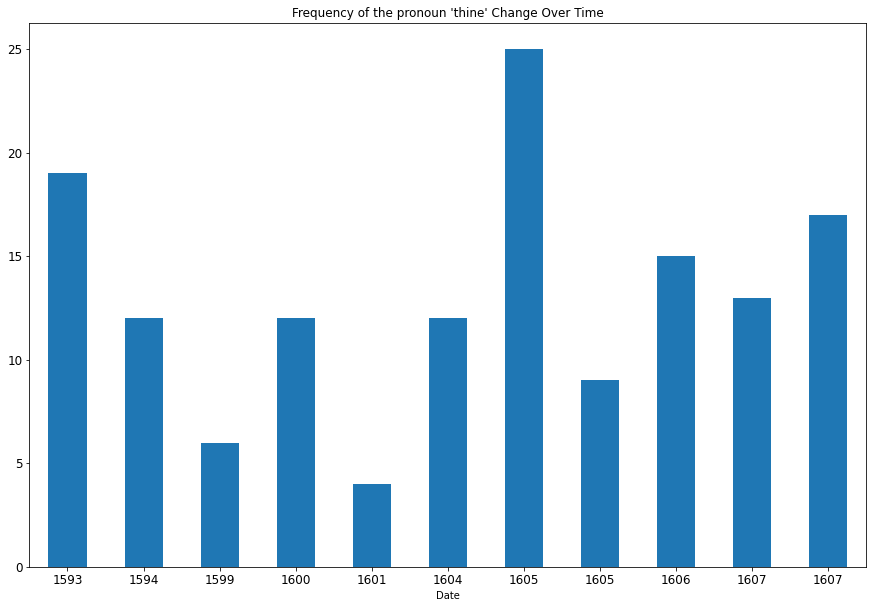

In [179]:
# visualize
df3 = df3.set_index('Date'); 
plt.figure()
ax3 = df3[['total_number']].plot(
    kind='bar',
    title ="Frequency of the pronoun 'thine' Change Over Time",
    figsize=(15, 10),
    legend=False,
    fontsize=12)
for tick in ax3.get_xticklabels():
    tick.set_rotation(0)

plt.show()

The year of production did not affect the usage of these pronouns as predicted. Archaic pronouns did not decrease mainly because of the plots in which characters had casual/intimate relationships – the social usage of 'you' and 'your' could not dominate the drama realm. ​